In [ ]:
d="F:/EPIC-KITCHEN-100"
f="F:/2g1n6qdydwa9u22shpxqzp0t8m"

In [139]:
import AcTOL
import torch
import matplotlib.pyplot as plt
from PIL import Image
# Load AcTOL model
plt.style.use("default")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AcTOL.load("AcTOL", device=device)

===========Loading AcTOL Model==============
========= Load Successfully ========


In [140]:
# image = Image.open("F:/EPIC-KITCHEN-100/P01/rgb_frames/P01_104/frame_0000000051.jpg")
# text = "pick up cup"
#
# with torch.no_grad():
#     image_features_1 = model.encode_image(image)
#     text_features_1 = model.encode_text(text)
#     reward_1 = model.get_reward(image, text)

In [141]:
# def inspect(x, name="var"):
#     print(f"\n[{name}]")
#     print("  type:", type(x))
#     print("  is torch.Tensor:", isinstance(x, torch.Tensor))
#     if isinstance(x, torch.Tensor):
#         print("  shape:", tuple(x.shape))
#         print("  dtype:", x.dtype)
#         print("  device:", x.device)
#         print("  requires_grad:", x.requires_grad)
#
# inspect(image_features_1, "image_features_1")
# inspect(text_features_1, "text_features_1")
# inspect(reward_1, "reward")

In [142]:
# image = Image.open("F:/EPIC-KITCHEN-100/P01/rgb_frames/P01_104/frame_0000000055.jpg")
# text = "pick up cup"
#
# image_features_2 = model.encode_image(image)
# text_features_2 = model.encode_text(text)
# reward_2 = model.get_reward(image, text)

In [143]:
# import torch.nn.functional as F
#
# sim = F.cosine_similarity(text_features_1, text_features_2, dim=-1)  # shape: (1,)
# print(sim.item())

In [161]:
import os, numpy as np, torch
import matplotlib.pyplot as plt
from PIL import Image
import AcTOL

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = AcTOL.load("AcTOL", device=device)

def get_reward_curve(DATA_DIR, participant, video_id, start_f, end_f, instruction, num_points=None):
    idxs = np.linspace(start_f, end_f, num_points).round().astype(int)

    rewards = []
    kept = []

    for i in idxs:
        p = os.path.join(DATA_DIR, participant, "rgb_frames", video_id, f"frame_{i:010d}.jpg")
        if not os.path.exists(p):
            continue
        img = Image.open(p).convert("RGB")
        r = model.get_reward(img, instruction)
        rewards.append(float(r.detach().cpu().item() if torch.is_tensor(r) else r))
        kept.append(i)

    return np.array(kept), np.array(rewards, dtype=np.float32)

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from matplotlib.transforms import blended_transform_factory
from matplotlib.patches import FancyArrowPatch
def plot_curve_simple(
    rewards,
    title="",
    file_name="",
    save_dir=r"C:\Users\paichichi\Documents\GitHub\AcTOL\fail_Case",
    xlabel="Frame",
    vlines=("start","median", "end"),
    pad_ratio=0.04,
    line_color="#b0124a",
    vline_lw=1.2,
    curve_lw=2.2,
    arrow_depth=0.25,   # 箭头往下延伸比例（越大越“超过图片很多”）
):
    rewards = np.asarray(rewards, dtype=np.float32)
    r = (rewards - rewards.min()) / (rewards.max() - rewards.min() + 1e-8)

    # alpha = 80
    # r = 1.0 / (1.0 + np.exp(-alpha * rewards))
    n = len(r)
    x = np.arange(n)

    fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    ax.plot(x, r, color=line_color, lw=curve_lw)

    ax.set_ylim(0, 1.02)
    ax.set_ylabel("Normalized Reward")
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.grid(False)

    pad = max(1, int((n - 1) * pad_ratio))
    ax.set_xlim(-pad, (n - 1) + pad)

    # vline positions
    pos = []
    if "start" in vlines:  pos.append((0, "start"))
    if "median" in vlines: pos.append((n // 2, "median"))
    if "end" in vlines:    pos.append((n - 1, "end"))

    # blended transform: x 用 data，y 用 axes fraction
    trans = blended_transform_factory(ax.transData, ax.transAxes)

    ymin, ymax = ax.get_ylim()
    yrange = (ymax - ymin) if (ymax - ymin) != 0 else 1.0

    dash = (0, (4, 3))  # 统一虚线样式

    head_len = 0.06   # 头部高度（axes fraction），可调：0.04~0.08

    for idx, lab in pos:
        y_data = float(r[idx])
        y_frac = (y_data - ymin) / yrange

        # ✅ 虚线只画到“箭头头部起点”，不要画进箭头区域
        ax.plot(
            [idx, idx], [y_frac, -arrow_depth + head_len],
            transform=trans,
            color="black",
            linestyle=dash,
            linewidth=vline_lw,
            alpha=0.9,
            zorder=6,
            clip_on=False
        )

        # ✅ 只画箭头头部（无杆），占据最后 head_len 那段
        head = FancyArrowPatch(
            (idx, -arrow_depth + head_len),
            (idx, -arrow_depth),
            transform=trans,
            arrowstyle='-|>',
            mutation_scale=12,
            linewidth=0,
            color="black",
            zorder=7,
            clip_on=False
        )
        ax.add_patch(head)

    # 给底部留更大空间容纳“很长的箭头”
    fig.subplots_adjust(bottom=0.12 + arrow_depth * 0.9)

    # save
    if file_name:
        save_path = Path(save_dir) / file_name
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=300, bbox_inches="tight", facecolor="white")

    plt.show()

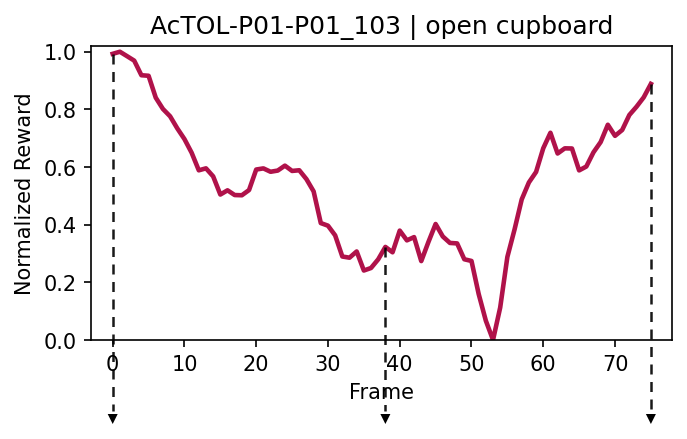

closest to 1 (raw cosine): idx = 1 reward = -0.013848182745277882 frame id= 1405
farthest from 1: idx = 53 reward = -0.05526871234178543 frame id = 1457


In [167]:
plt.style.use("default")
DATA_DIR = "F:/EPIC-KITCHEN-100/"
participant = "P01"
video_id = "P01_103"
start_frame, end_frame = 1405, 1481
instruction = "open cupboard"

frame_ids, rewards = get_reward_curve(DATA_DIR, participant, video_id, start_frame, end_frame, instruction, num_points=end_frame - start_frame)
plot_curve_simple(rewards, title=f"AcTOL-{participant}-{video_id} | {instruction}", file_name = instruction + '.JPG', arrow_depth=0.3)

r = np.asarray(rewards, dtype=float)
idx = int(np.argmax(r))
val = float(r[idx])
print("closest to 1 (raw cosine): idx =", idx, "reward =", val, 'frame id=', start_frame + idx - 1)


r = np.asarray(rewards, dtype=float)
idx_far = int(np.argmax(np.abs(r - 1.0)))
val_far = float(r[idx_far])
print("farthest from 1: idx =", idx_far, "reward =", val_far, "frame id =",start_frame + idx_far - 1)


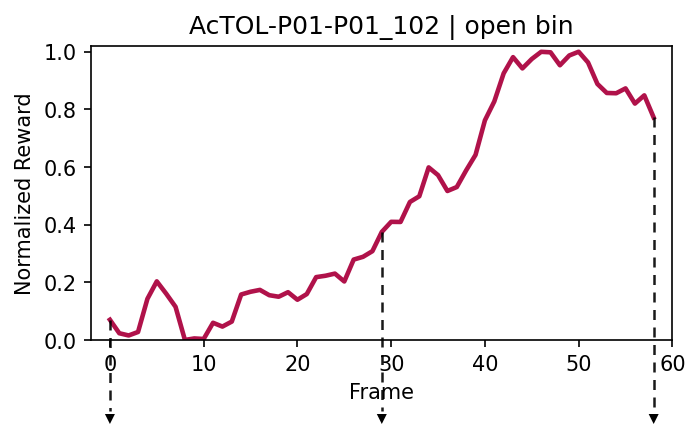

closest to 1 (raw cosine): idx = 50 reward = -0.030938463285565376 frame id= 532
farthest from 1: idx = 8 reward = -0.07172130793333054 frame id = 490


In [168]:
plt.style.use("default")
DATA_DIR = "F:/EPIC-KITCHEN-100/"
participant = "P01"
video_id = "P01_102"
start_frame, end_frame = 483, 542
instruction = "open bin"

frame_ids, rewards = get_reward_curve(DATA_DIR, participant, video_id, start_frame, end_frame, instruction, num_points=end_frame - start_frame)
plot_curve_simple(rewards, title=f"AcTOL-{participant}-{video_id} | {instruction}", file_name = instruction + '.JPG', arrow_depth=0.3)

r = np.asarray(rewards, dtype=float)
idx = int(np.argmax(r))
val = float(r[idx])
print("closest to 1 (raw cosine): idx =", idx, "reward =", val, 'frame id=', start_frame + idx - 1)


r = np.asarray(rewards, dtype=float)
idx_far = int(np.argmax(np.abs(r - 1.0)))
val_far = float(r[idx_far])
print("farthest from 1: idx =", idx_far, "reward =", val_far, "frame id =",start_frame + idx_far - 1)


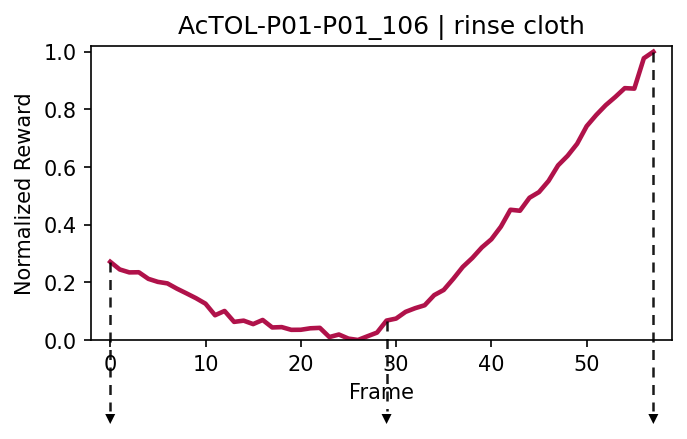

closest to 1 (raw cosine): idx = 57 reward = 0.031548529863357544 frame id= 19598
farthest from 1: idx = 26 reward = -0.05937808379530907 frame id = 19567


In [169]:
plt.style.use("default")
DATA_DIR = "F:/EPIC-KITCHEN-100/"
participant = "P01"
video_id = "P01_106"
start_frame, end_frame = 19542, 19600
instruction = "rinse cloth"

frame_ids, rewards = get_reward_curve(DATA_DIR, participant, video_id, start_frame, end_frame, instruction, num_points=end_frame - start_frame)
plot_curve_simple(rewards, title=f"AcTOL-{participant}-{video_id} | {instruction}", file_name = instruction + '.JPG', arrow_depth=0.3)

r = np.asarray(rewards, dtype=float)
idx = int(np.argmax(r))
val = float(r[idx])
print("closest to 1 (raw cosine): idx =", idx, "reward =", val, 'frame id=', start_frame + idx - 1)


r = np.asarray(rewards, dtype=float)
idx_far = int(np.argmax(np.abs(r - 1.0)))
val_far = float(r[idx_far])
print("farthest from 1: idx =", idx_far, "reward =", val_far, "frame id =",start_frame + idx_far - 1)


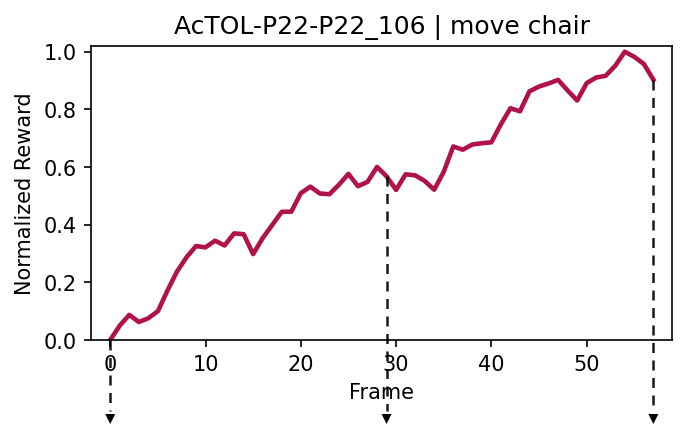

closest to 1 (raw cosine): idx = 54 reward = 0.008335694670677185 frame id= 22122
farthest from 1: idx = 0 reward = -0.030491190031170845 frame id = 22068


In [170]:
plt.style.use("default")
DATA_DIR = "F:/EPIC-KITCHEN-100/"
participant = "P22"
video_id = "P22_106"
start_frame, end_frame = 22069, 22127
instruction = "move chair"

frame_ids, rewards = get_reward_curve(DATA_DIR, participant, video_id, start_frame, end_frame, instruction, num_points=end_frame - start_frame)
plot_curve_simple(rewards, title=f"AcTOL-{participant}-{video_id} | {instruction}", file_name = instruction + '.JPG', arrow_depth=0.3)

r = np.asarray(rewards, dtype=float)
idx = int(np.argmax(r))
val = float(r[idx])
print("closest to 1 (raw cosine): idx =", idx, "reward =", val, 'frame id=', start_frame + idx)


r = np.asarray(rewards, dtype=float)
idx_far = int(np.argmax(np.abs(r - 1.0)))
val_far = float(r[idx_far])
print("farthest from 1: idx =", idx_far, "reward =", val_far, "frame id =",start_frame + idx_far)


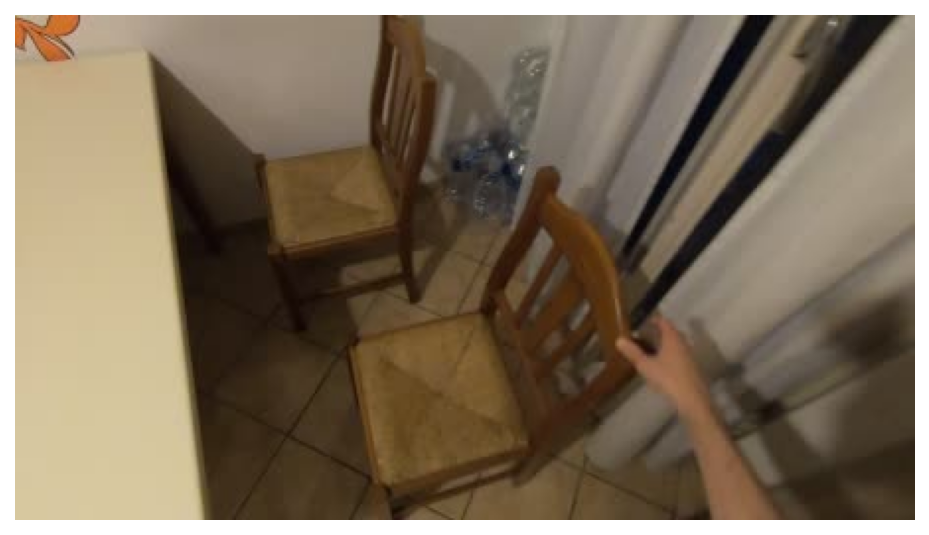

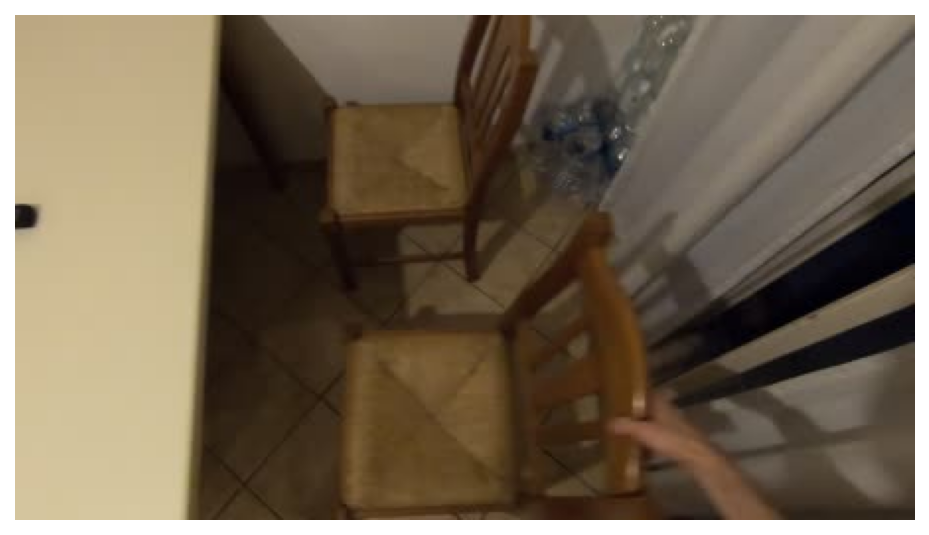

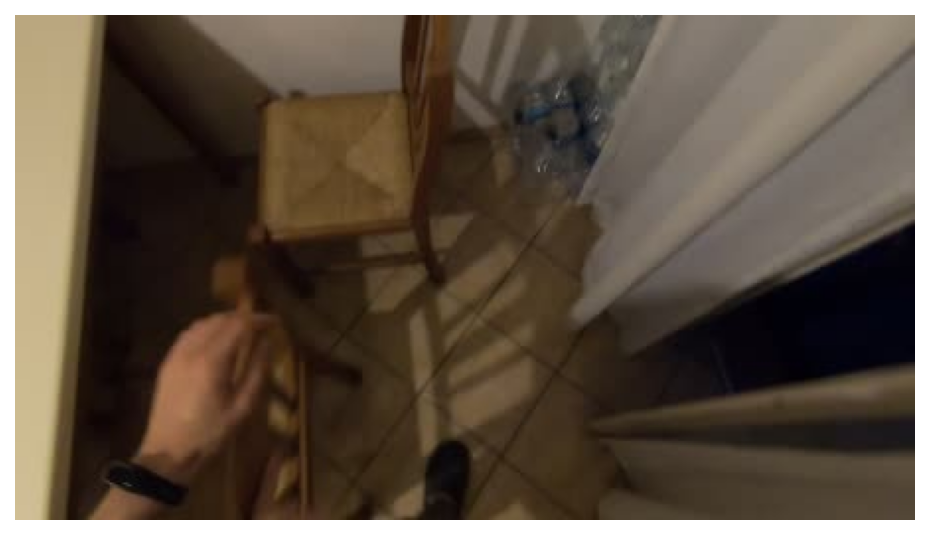

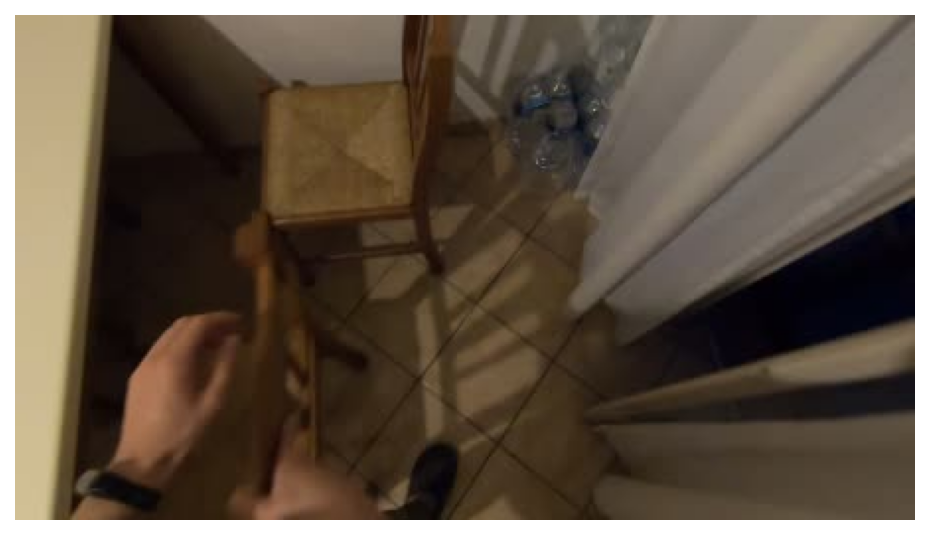

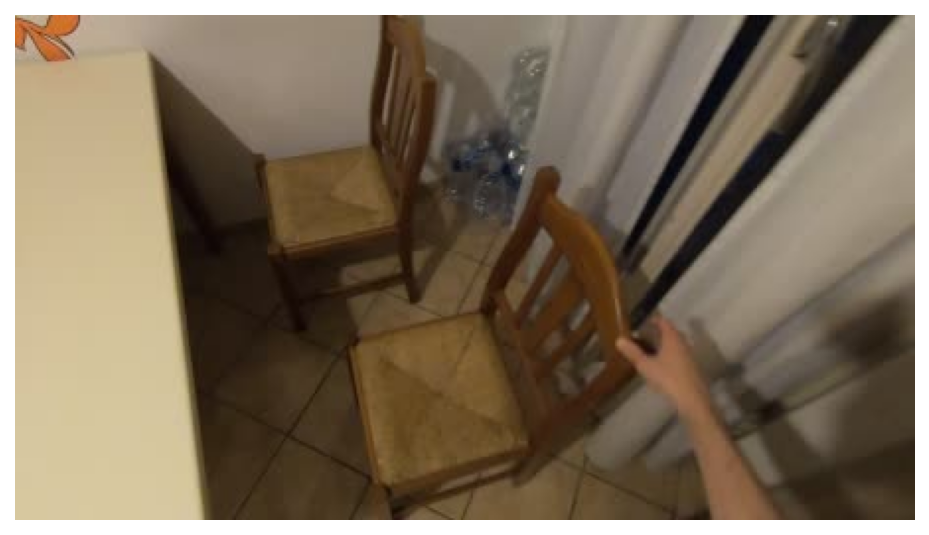

In [171]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
# 你已有：
# frame_ids, rewards = get_reward_curve(...)

def frame_path(data_dir, participant, video_id, frame_id):
    return Path(data_dir) / participant / "rgb_frames" / video_id / f"frame_{int(frame_id):010d}.jpg"

def find_existing_frame(frame_id, radius=200):
    """如果指定帧不存在，向两边找最近存在的一帧"""
    p0 = frame_path(DATA_DIR, participant, video_id, frame_id)
    if p0.exists():
        return frame_id, p0
    for d in range(1, radius + 1):
        for cand in (frame_id - d, frame_id + d):
            p = frame_path(DATA_DIR, participant, video_id, cand)
            if p.exists():
                return cand, p
    return None, None

def show_image_only(img):
    plt.figure(figsize=(6, 6), dpi=150)
    plt.imshow(img)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

# ---- 1) 计算 5 个目标帧 ----
mid_frame = start_frame + (end_frame - start_frame) // 2

r = np.asarray(rewards, dtype=float)
idx_best = int(np.argmax(r))
idx_far  = int(np.argmax(np.abs(r - 1.0)))

best_frame = int(frame_ids[idx_best])   # ✅ 用 frame_ids 映射真实帧号
far_frame  = int(frame_ids[idx_far])

frames_to_show = [start_frame, mid_frame, end_frame, best_frame, far_frame]

# ---- 2) 一张一张显示 ----
for fid in frames_to_show:
    real_fid, p = find_existing_frame(fid, radius=200)
    if p is None:
        print(f"[NOT FOUND] frame {fid}")
        continue
    img = Image.open(p).convert("RGB")
    show_image_only(img)